## HW4

In [521]:
Events_Time = [("Asian financial crisis", (1997, 1998)), ("Dot com bubble", (2001, 2002)), ("Global financial crisis", (2007, 2008)), ("Political and sovereign debt issue in EU", (2011, 2012)), ("Covid-19 Pandemic", (2021, 2022))]

In [522]:
import numpy as np
from matplotlib import pyplot as plt
import yfinance
import pandas as pd
from pathlib import Path
import warnings

data = pd.read_csv("^GSPC.csv", index_col="Date")
data.index = pd.to_datetime(data.index)

def get_ATR(data: pd.DataFrame, start: str, end: str, event_name: str="", n=14, worst=5):
    """
    event_name -> graph name
    data -> orignial data
    start -> a start year in crisis event
    end -> a end year in crisis event 
    n -> a period to compute ATR
    worst -> a number of worst days
    """
    def get_ATR(data):
        TR = max(data["High"] - data["Low"], abs(data["Pc"] - data["High"]), abs(data["Low"] - data["Pc"]))
        return TR
    event_data = data.loc[str(start)+"-01-01": str(end)+"-12-31"]
    event_data["Daily Return"] = event_data["Close"].pct_change()
    event_data["Pc"] = event_data["Close"].shift()
    event_data["TR"] = event_data.apply(get_ATR, axis=1)
    event_data["ATR"] = 0
    event_data.at[event_data.index[n], "ATR"] = event_data["TR"][:n].mean()
    for i in range(n+1, event_data.shape[0]):
        index = event_data.index[i]
        index_previous = event_data.index[i-1]
        event_data.at[index, "ATR"] = ((event_data.at[index_previous, "ATR"] * (n - 1) + event_data.at[index, "TR"])) / n
    worst_days = event_data.sort_values(by="Daily Return").iloc[:worst]
    # print(f"top 5 worst days: {list(worst_days.index)}")
    plt.figure(event_name)
    plt.title(f"{event_name} ATR: n={n}")
    #I exclude the previous n day.
    plt.plot(event_data.index[n+1:], event_data["ATR"].iloc[n+1:], label="ATR of S&P 500")
    for date in worst_days.index[:-1]:
        plt.axvline(date, c="r", alpha=0.8, linestyle="-")
    plt.axvline(worst_days.index[-1], c="r", alpha=0.8, linestyle="-", label=f"Worst {worst_days.shape[0]} Days")
    plt.axhline(worst_days["ATR"].mean(), c="g", alpha=0.8, linestyle="-", label="Avg of ATR in Worst Days")
    plt.legend(loc="upper left")
    plt.grid()
    try:
        plt.savefig(f"./ATR/{event_name}_ATR.png")
    except FileNotFoundError as e:
        print("Catch")
        Path("./ATR/").mkdir()
        plt.savefig(f"./ATR/{event_name}_ATR.png")
    plt.show()



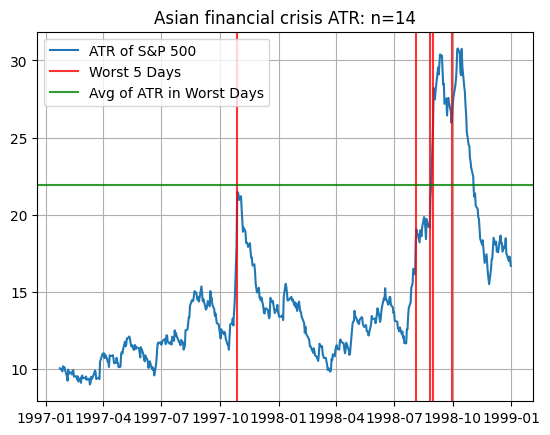

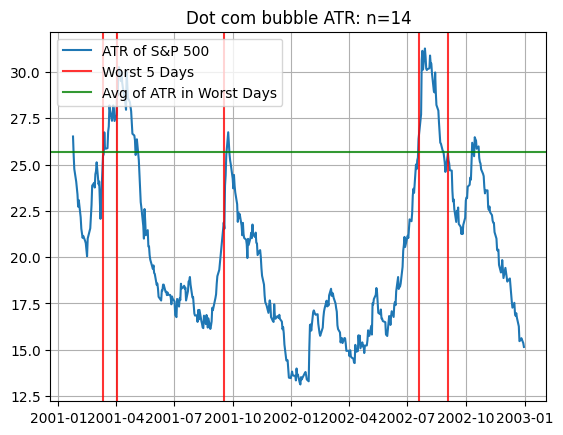

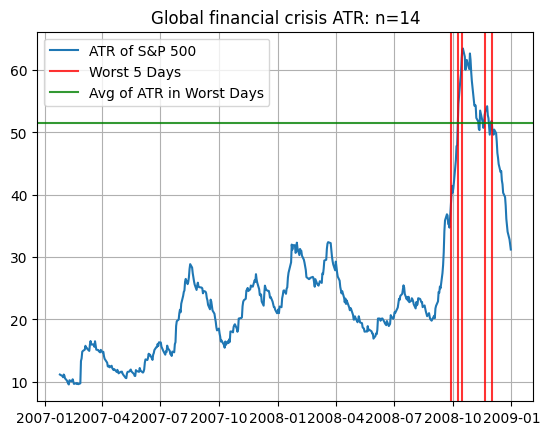

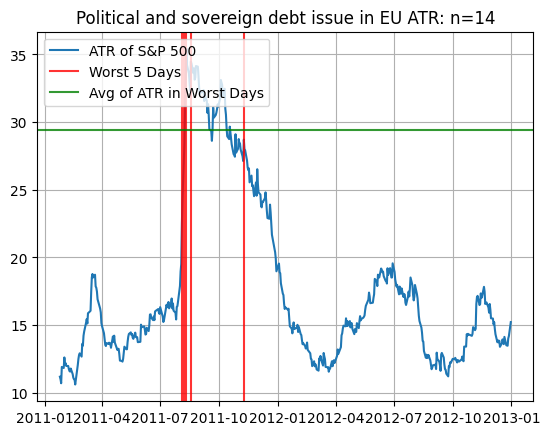

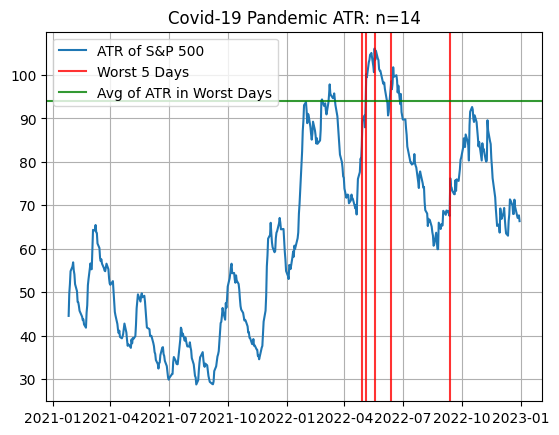

In [523]:
for event in Events_Time:
    get_ATR(data, *event[1], event[0])


In [524]:
def get_SC(data: pd.DataFrame, start: str, end: str, event_name: str="", n=3, worst=5):
    def cal_K_Line(row):
        answer = (row["Close"] - row["Low"]) / (row["High"] - row["Low"]) * 100
        return answer
    def get_signal(row):
        if (row["Diff_Yesterday"]) < 0 and (row["Diff_Today"]) > 0:
            return 1
        elif (row["Diff_Yesterday"]) > 0 and (row["Diff_Today"]) < 0:
            return -1
        else:
            return 0
    event_data = data.loc[str(start)+"-01-01": str(end)+"-12-31"]
    event_data["Daily Return"] = event_data["Close"].pct_change()
    event_data["K_Line"] = event_data.apply(cal_K_Line, axis=1)
    event_data["D_Line"] = event_data["K_Line"].rolling(n).mean()
    event_data.dropna(inplace=True)
    event_data["K_Line_Yesterday"], event_data["D_Line_Yesterday"] = event_data["K_Line"].shift(1), event_data["D_Line"].shift(1)
    event_data["Diff_Yesterday"] = event_data["K_Line_Yesterday"] - event_data["D_Line_Yesterday"]
    event_data["Diff_Today"] = event_data["K_Line"] - event_data["D_Line"]
    event_data["Signal"] = event_data.apply(get_signal, axis=1)

    # print(event_data[["Close", "Daily Return", "Diff_Yesterday", "Diff_Today", "Signal"]].tail())

    worst_days = event_data.sort_values(by="Daily Return")[:worst]

    plt.figure()
    plt.title(event_name + " Close Price")
    for date in worst_days.index[:-1]:
        plt.axvline(date, c="r", alpha=0.8, linestyle="-")
    plt.axvline(worst_days.index[-1], c="r", alpha=0.8, linestyle="-", label=f"Top {worst} Worst Days")
    plt.plot(event_data.index, event_data["Close"], label="Close Price")
    plt.scatter(event_data[event_data["Signal"]==1].index, event_data["Close"][event_data["Signal"]==1], marker="^", c="g", s=10, label="long point")
    plt.scatter(event_data[event_data["Signal"]==-1].index, event_data["Close"][event_data["Signal"]==-1], marker="v", c="r", s=10, label="short point")
    plt.legend(loc="best")
    plt.grid(alpha=0.3)

    plt.figure()
    plt.title(event_name + " Stochastic Ocillator")
    plt.plot(event_data.index, event_data["K_Line"], label="K_Line")
    plt.plot(event_data.index, event_data["D_Line"], label="D_Line")
    for date in worst_days.index[:-1]:
        plt.axvline(date, c="black", alpha=0.8, linestyle="-")
    plt.axvline(worst_days.index[-1], c="black", alpha=0.8, linestyle="-", label=f"Top {worst} Worst Days")
    plt.legend(loc="upper left")
    plt.grid(alpha=0.3)
    try:
        plt.savefig(f"./SC/{event_name}_SC.png")
    except FileNotFoundError as e:
        print("Catch")
        Path("./SC/").mkdir()
        plt.savefig(f"./SC/{event_name}_SC.png")
    plt.show()


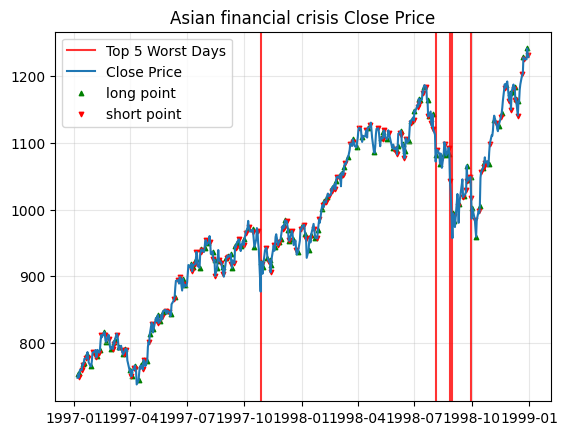

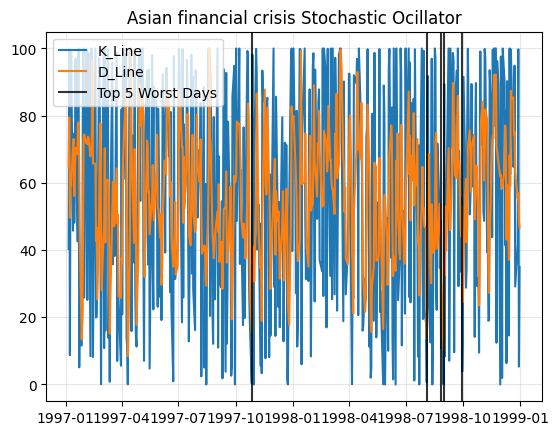

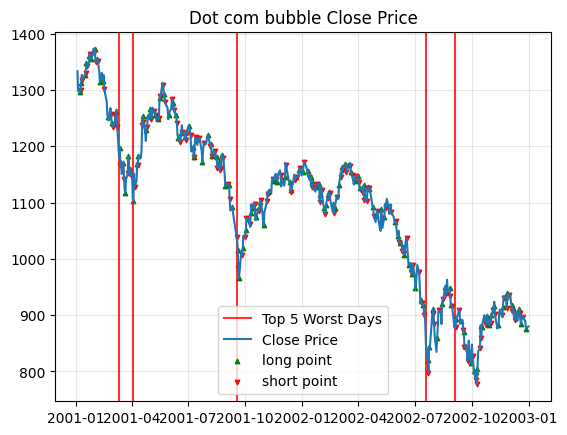

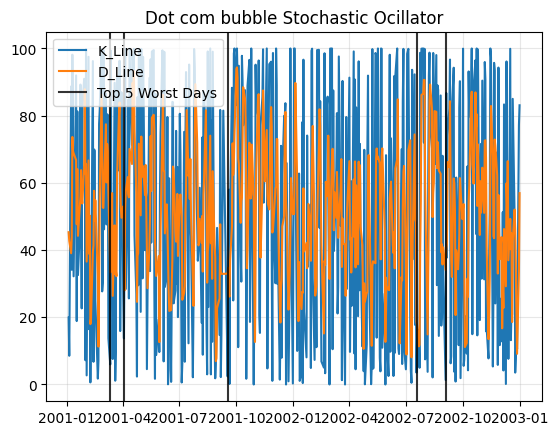

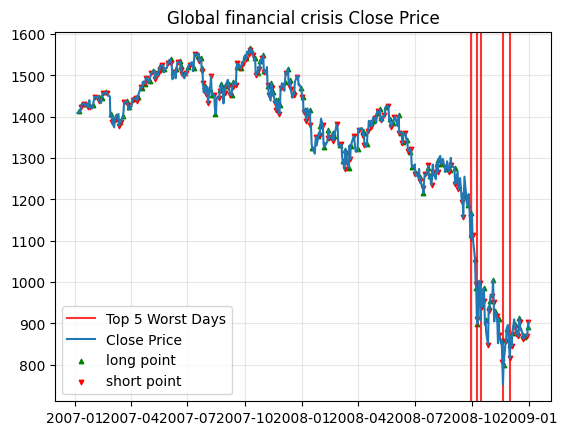

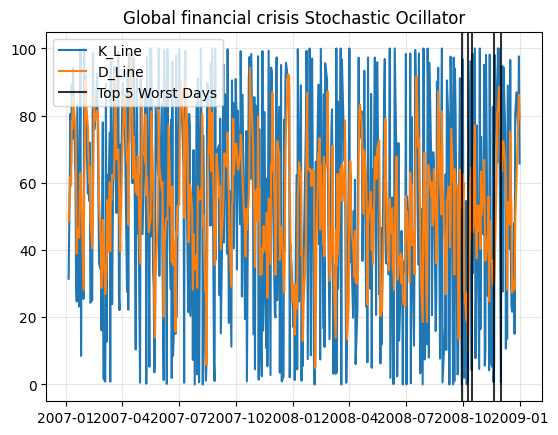

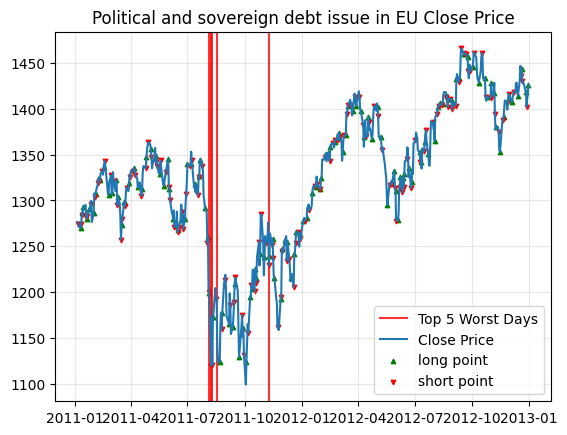

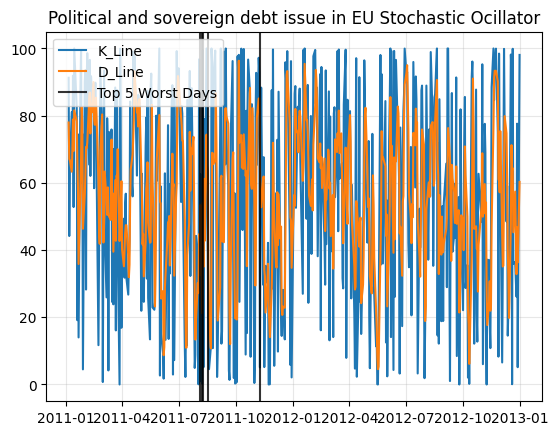

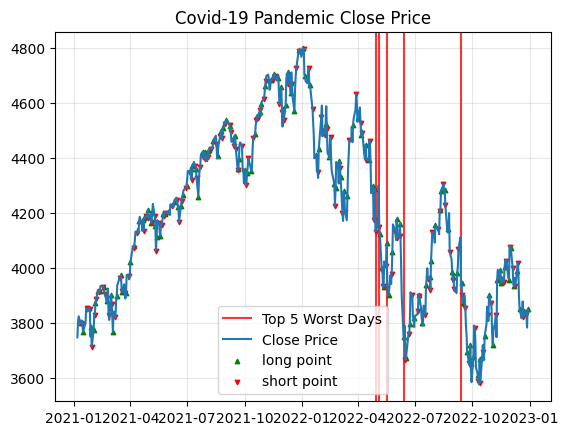

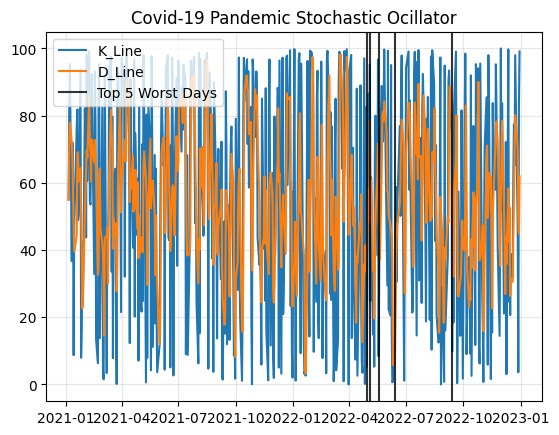

In [525]:
for event in Events_Time:
    get_SC(data, *event[1], event[0])

In [526]:
def get_RSI(data: pd.DataFrame, start: str, end: str, event_name: str="", n=14, worst=5):
    event_data = data.loc[str(start)+"-01-01" : str(end)+"-12-31", :]
    event_data["Daily Return"] = event_data["Close"].pct_change()
    event_data["Diff"] = event_data["Close"].diff()
    event_data["Gain"], event_data["Loss"] = event_data.Diff[event_data["Diff"]>0], abs(event_data.Diff[event_data["Diff"]<0])
    event_data.fillna(0, inplace=True)
    event_data["Average Gain"], event_data["Average Loss"] = event_data["Gain"].rolling(n).mean(), event_data["Loss"].rolling(n).mean()
    # print(event_data[["Average Gain", "Average Loss"]][event_data["Average Loss"]==0], event_data[["Average Gain", "Average Loss"]][event_data["Average Loss"]==0].shape)


    event_data["Relative Strength"] = event_data["Average Gain"] / event_data["Average Loss"]
    event_data.dropna(inplace=True)
    event_data["Relative Strength Index"] = 100 - 100 / (1 + event_data["Relative Strength"])
    worst_days = event_data.sort_values(by="Daily Return")[:worst]
    print(event_data["Relative Strength Index"])

    plt.figure(event_name)
    plt.title(event_name)
    #I exclude the previous n day.
    plt.plot(event_data.index, event_data["Close"], label="Close Price of S&P 500")
    for date in worst_days.index[:-1]:
        plt.axvline(date, c="r", alpha=0.8, linestyle="-")
    plt.axvline(worst_days.index[-1], c="r", alpha=0.8, linestyle="-", label=f"Worst {worst_days.shape[0]} Days")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

    plt.figure()
    plt.title(f"{event_name} Relative Strenght Index: n={n}")
    plt.plot(event_data.index, event_data["Relative Strength Index"], label="Relative Strength Index")
    for date in worst_days.index[:-1]:
        plt.axvline(date, c="r", alpha=0.8, linestyle="-")
    plt.axvline(worst_days.index[-1], c="r", alpha=0.8, linestyle="-", label=f"Worst {worst_days.shape[0]} Days")
    plt.axhline(0, c="black")
    plt.axhline(100, c="black")
    plt.legend()
    plt.grid(alpha=0.5)
    try:
        plt.savefig(f"./RSI/{event_name}_RSI.png")
    except FileNotFoundError as e:
        print("Catch")
        Path("./RSI/").mkdir()
        plt.savefig(f"./RSI/{event_name}_RSI.png")
    plt.show()

    # print(event_data[["Close", "Gain", "Loss", "Relative Strength", "Relative Strength Index"]][np.isclose(event_data["Relative Strength Index"], 100)])


Date
1997-01-21    88.457020
1997-01-22    89.100744
1997-01-23    74.368720
1997-01-24    67.003745
1997-01-27    58.776279
                ...    
1998-12-24    65.880104
1998-12-28    62.962212
1998-12-29    69.397188
1998-12-30    64.809837
1998-12-31    71.726279
Name: Relative Strength Index, Length: 492, dtype: float64


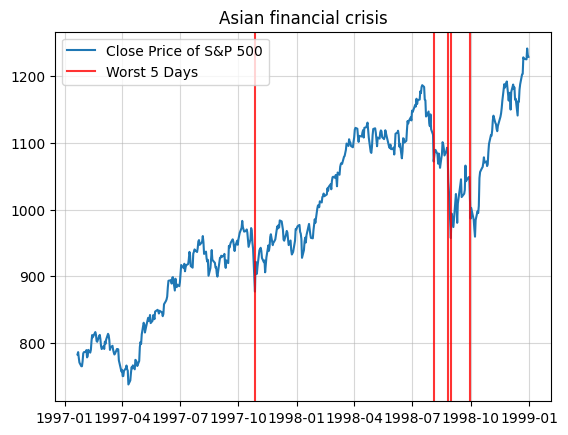

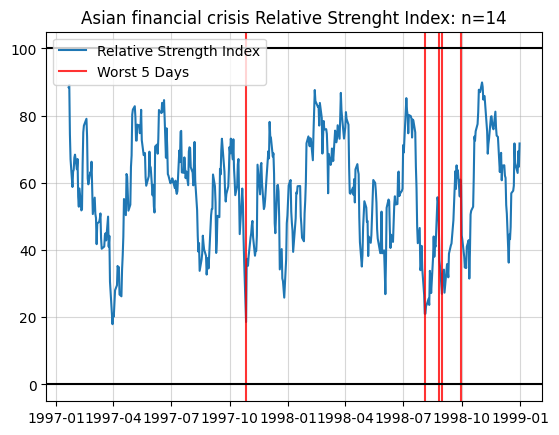

Date
2001-01-22    65.656689
2001-01-23    68.547125
2001-01-24    55.673042
2001-01-25    58.625397
2001-01-26    76.281610
                ...    
2002-12-24    40.378568
2002-12-26    43.093157
2002-12-27    35.926661
2002-12-30    44.498746
2002-12-31    37.995914
Name: Relative Strength Index, Length: 487, dtype: float64


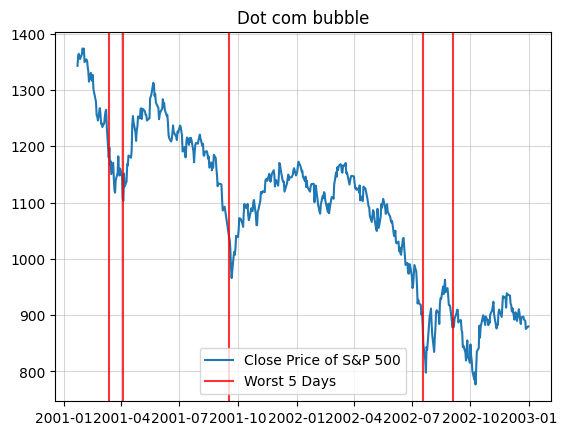

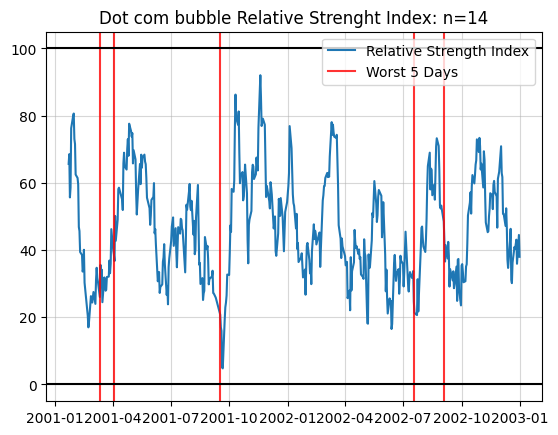

Date
2007-01-23    60.120833
2007-01-24    67.197760
2007-01-25    53.353467
2007-01-26    58.205076
2007-01-29    55.227098
                ...    
2008-12-24    54.701672
2008-12-26    49.248789
2008-12-29    39.252921
2008-12-30    50.525090
2008-12-31    51.057325
Name: Relative Strength Index, Length: 491, dtype: float64


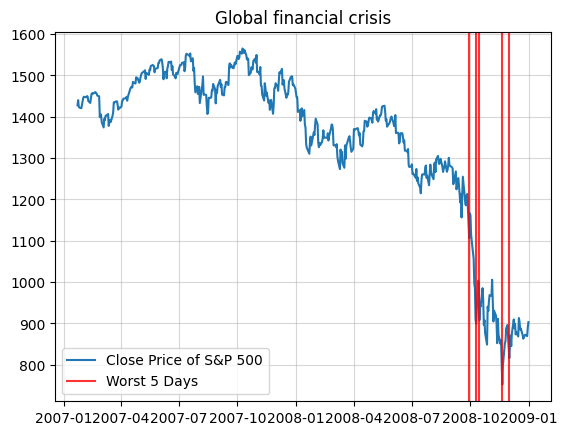

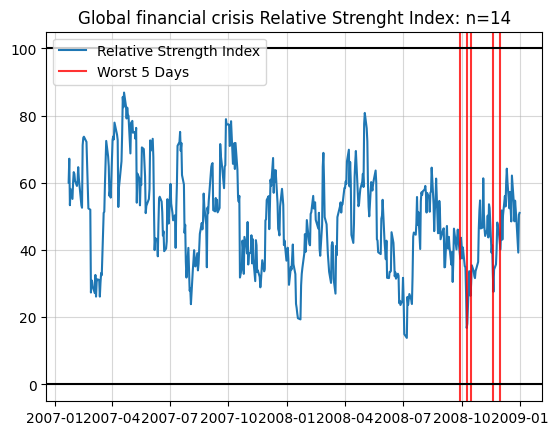

Date
2011-01-21    59.204587
2011-01-24    63.579058
2011-01-25    65.309442
2011-01-26    64.842442
2011-01-27    68.942698
                ...    
2012-12-24    59.300019
2012-12-26    54.794118
2012-12-27    51.942127
2012-12-28    43.408670
2012-12-31    52.691626
Name: Relative Strength Index, Length: 489, dtype: float64


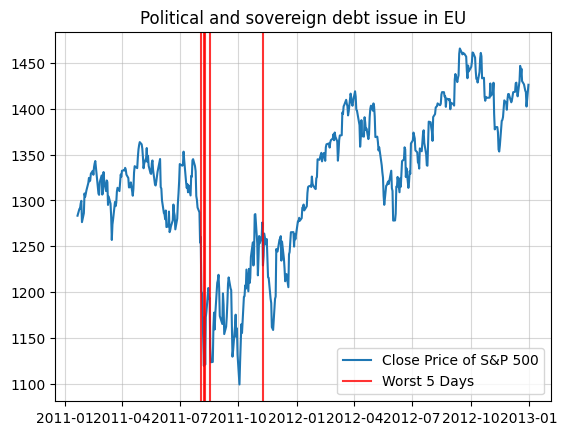

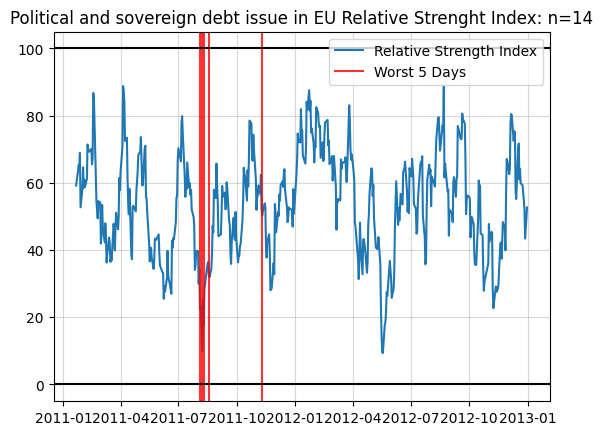

Date
2021-01-22    73.679967
2021-01-25    74.854624
2021-01-26    71.110195
2021-01-27    50.357034
2021-01-28    47.650927
                ...    
2022-12-23    36.002269
2022-12-27    38.978661
2022-12-28    36.220851
2022-12-29    40.208476
2022-12-30    41.588073
Name: Relative Strength Index, Length: 490, dtype: float64


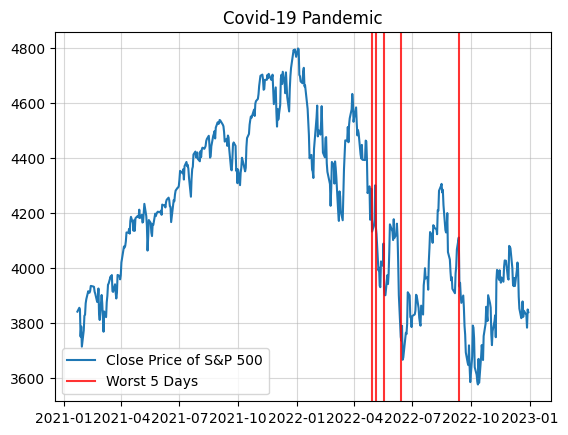

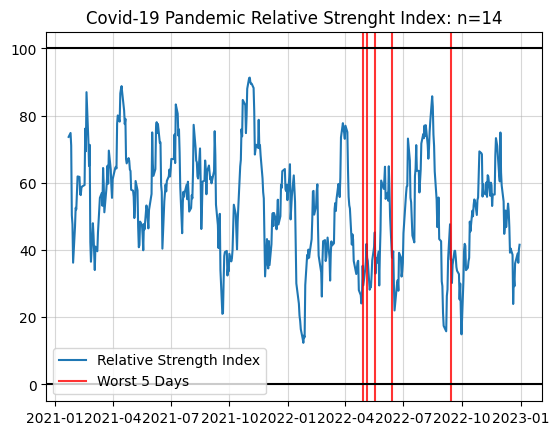

In [527]:
for event in Events_Time:
    get_RSI(data, *event[1], event[0])


In [528]:
def get_ROC(data: pd.DataFrame, start: str, end: str, event_name: str="", n=14, worst=5):
    event_data = data.loc[str(start)+"-01-01":str(end)+"-12-31", :]
    event_data["Daily Return"] = event_data["Close"].pct_change()
    event_data["N Days Close"] = event_data["Close"].shift(n)
    event_data["Rate Of Change"] = (event_data["Close"] - event_data["N Days Close"]) / event_data["N Days Close"] * 100
    worst_days = event_data.sort_values(by="Daily Return")[:worst]
    print((event_data["Rate Of Change"] > 0).sum())
    print((event_data["Rate Of Change"] < 0).sum())
    # print(event_data)
    plt.figure()
    plt.title(f"{event_name} Rate Of Change: n={n}")
    plt.plot(event_data.index, event_data["Rate Of Change"], label="Rate Of Change")
    for date in worst_days.index[:-1]:
        plt.axvline(date, c="r", alpha=0.8, linestyle="-")
    plt.axvline(worst_days.index[-1], c="r", alpha=0.8, linestyle="-", label=f"Worst {worst_days.shape[0]} Days")
    plt.fill_between(event_data.index, 0, event_data["Rate Of Change"], event_data["Rate Of Change"]>0, color='lightgreen')
    plt.fill_between(event_data.index, 0, event_data["Rate Of Change"], event_data["Rate Of Change"]<0, color='pink')
    plt.legend()
    plt.grid(alpha=0.5)
    try:
        plt.savefig(f"./ROC/{event_name}_ROC.png")
    except FileNotFoundError as e:
        print("Catch")
        Path("./ROC/").mkdir()
        plt.savefig(f"./ROC/{event_name}_ROC.png")
    plt.show()

329
162


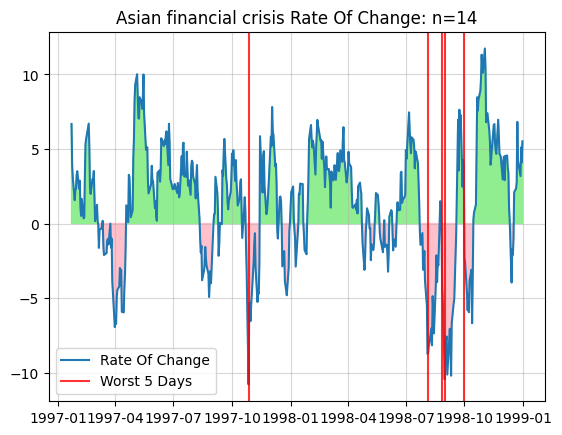

197
289


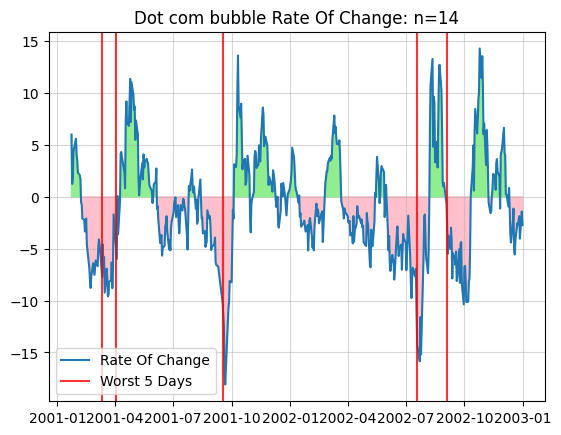

244
246


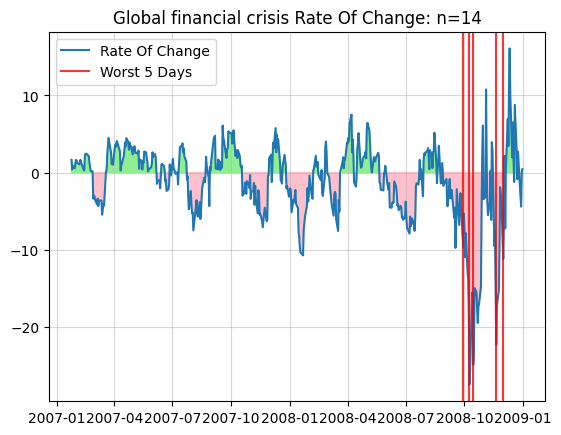

299
189


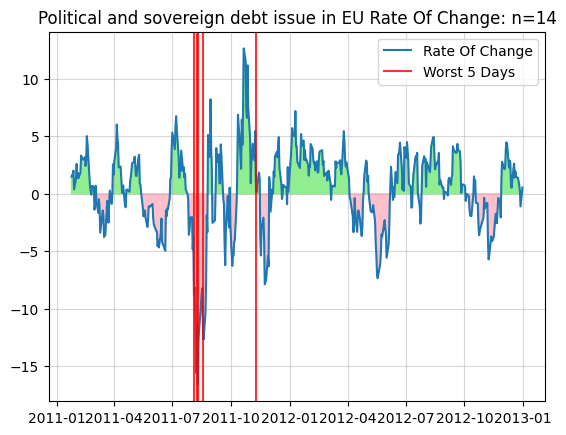

289
200


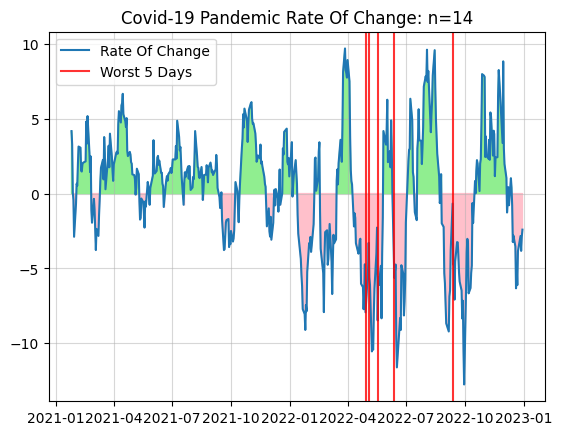

In [529]:
for event in Events_Time:
    get_ROC(data, *event[1], event[0])

In [530]:
def get_Close_Price(data: pd.DataFrame, start: str, end: str, event_name: str="", worst=5):
    event_data = data.loc[str(start)+"-01-01":str(end)+"-12-31", :]
    event_data["Daily Return"] = event_data["Close"].pct_change()
    worst_days = event_data.sort_values(by="Daily Return")[:worst]
    plt.figure()
    plt.title(event_name)
    for date in worst_days.index[:-1]:
        plt.axvline(date, c="r", alpha=0.8, linestyle="-")
    plt.axvline(worst_days.index[-1], c="r", alpha=0.8, linestyle="-", label=f"Top {worst} Worst Days")
    plt.plot(event_data.index, event_data["Close"], label="S&P 500 Close Price")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.5)
    plt.legend()
    Path("./Close_Price").mkdir(exist_ok=True)
    plt.savefig(f"./Close_Price/{event_name}_Close_Price.png")
    plt.show()



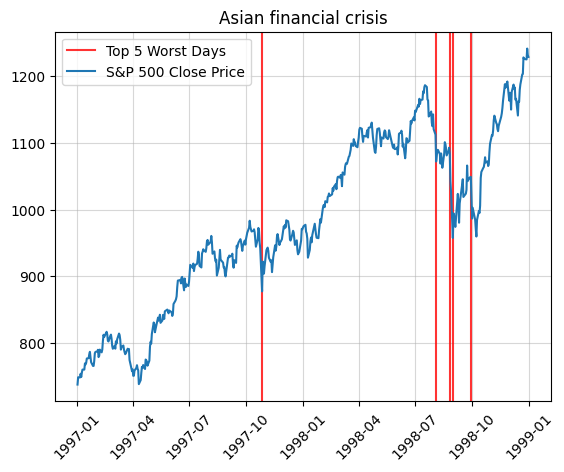

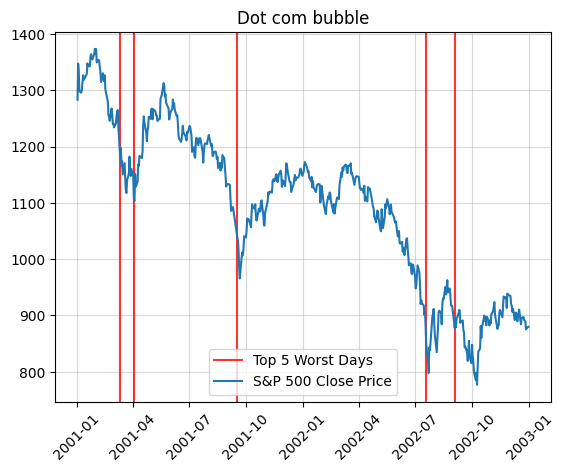

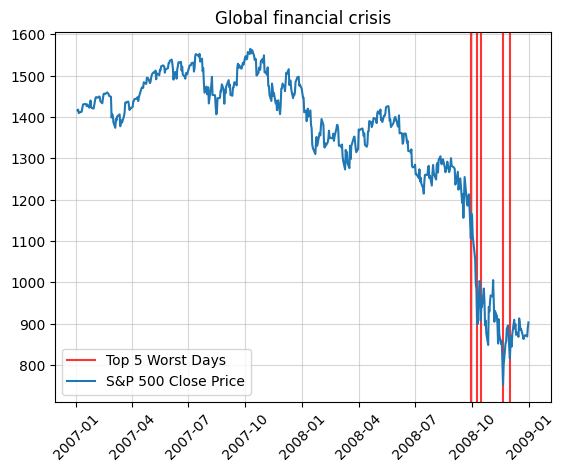

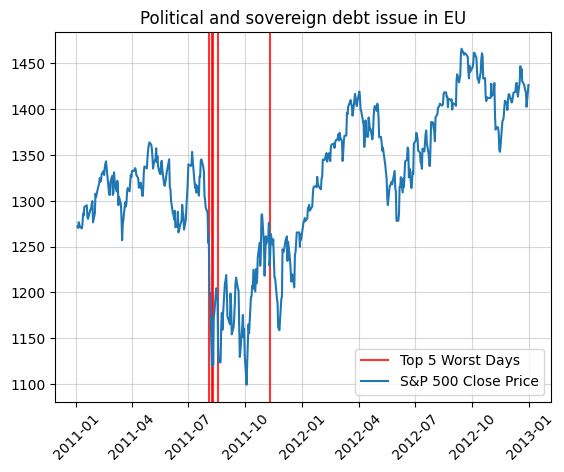

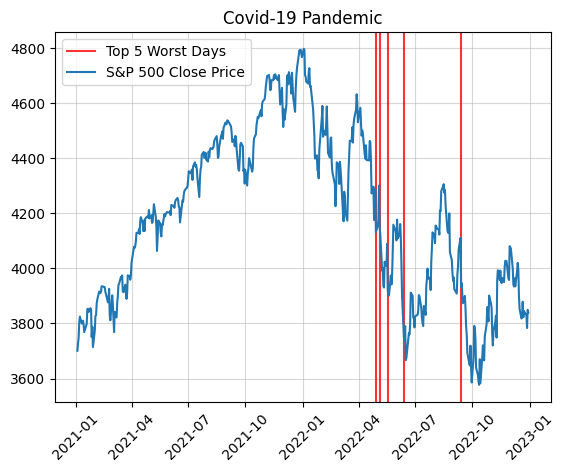

In [531]:
for event in Events_Time:
    get_Close_Price(data, *event[1], event[0])

In [532]:
start = 2019
end = 2024
name = "Pre & After Crises"

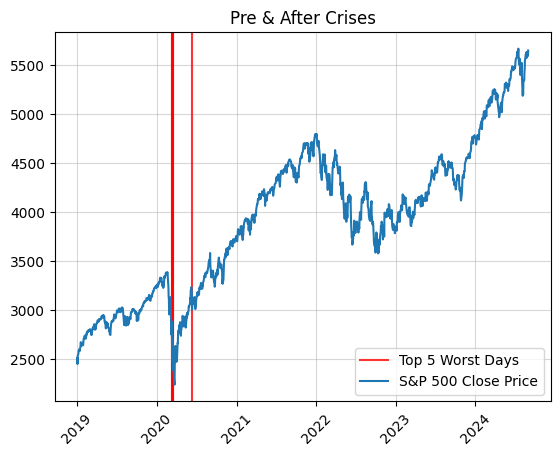

In [533]:
get_Close_Price(data, start, end, name)

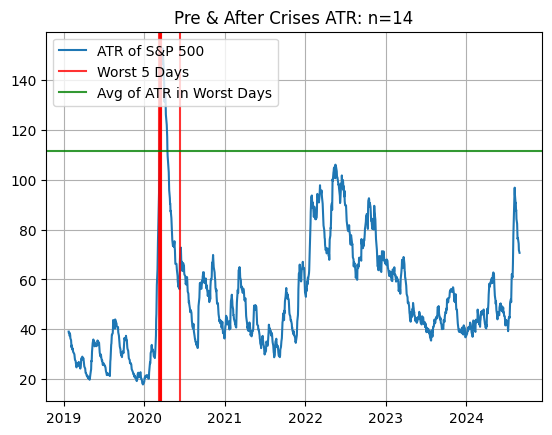

In [534]:
get_ATR(data, start, end, name)

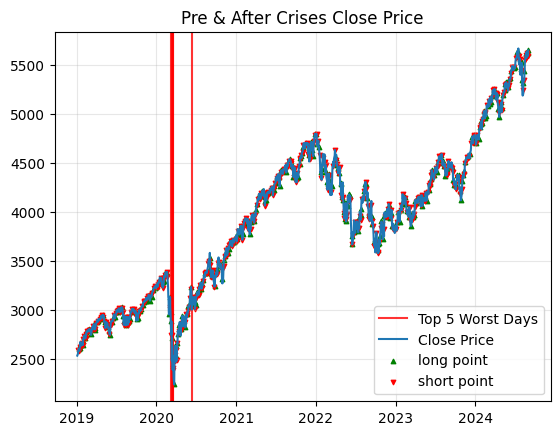

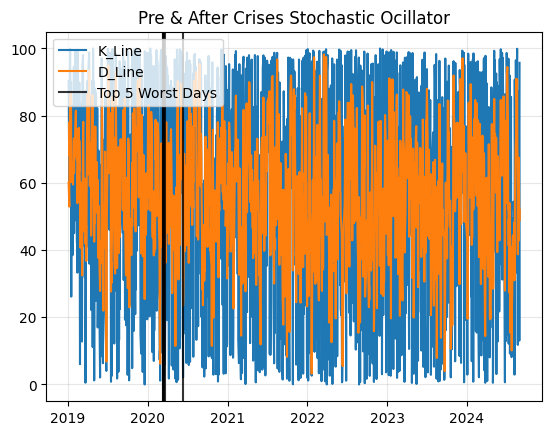

In [535]:
get_SC(data, start, end, name)

Date
2019-01-22    67.511320
2019-01-23    68.039700
2019-01-24    82.611074
2019-01-25    78.080382
2019-01-28    69.644556
                ...    
2024-08-26    80.580796
2024-08-27    86.465831
2024-08-28    77.378505
2024-08-29    76.155817
2024-08-30    78.685082
Name: Relative Strength Index, Length: 1413, dtype: float64


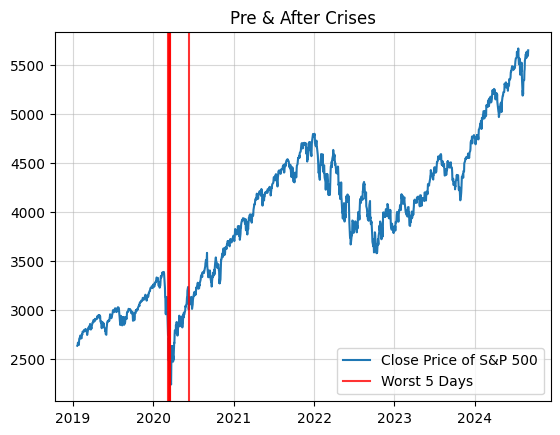

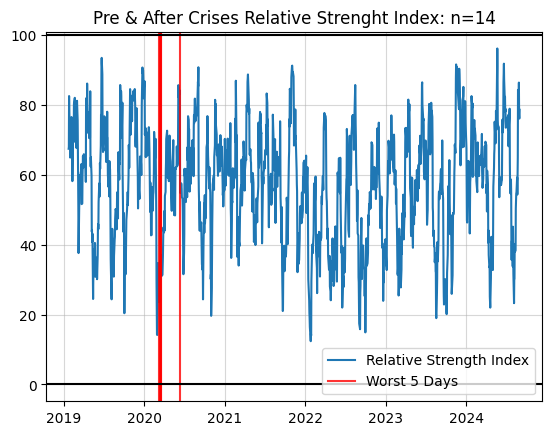

In [536]:
get_RSI(data, start, end, name)

967
445


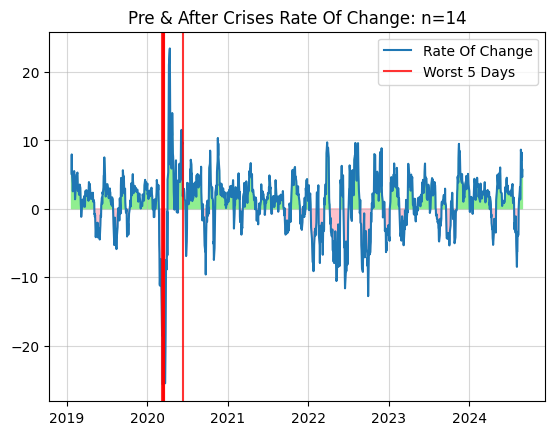

In [537]:
get_ROC(data, start, end, name)